In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import soaplite
import soaputils as su
import genBasis
import ase
from ase.visualize import view
from ase.build import bulk
import numpy as np
from numpy.linalg import svd
import matplotlib as matplotlib
import matplotlib.pyplot as p
import numpy.linalg as nl
from scipy.optimize import fmin
import scipy.optimize as op
from scipy.spatial.distance import cdist
import time
%matplotlib notebook

In [2]:
rCut = 10.0
NradBas = 5
Lmax = 5
myAlphas, myBetas = genBasis.getBasisFunc(rCut, NradBas)

struct1 = ase.io.read(currentdir + "/glass_cube_CuZr.cfg")
mat1 = soaplite.get_periodic_soap_structure(struct1, myAlphas, myBetas, rCut, NradBas, Lmax)

struct2 = bulk('Cu', 'fcc', a=3.6, cubic=True)
struct2 = soaplite._get_supercell(struct2, rCut=2.0)
mat2 = soaplite.get_periodic_soap_structure(struct2, myAlphas, myBetas, rCut, NradBas, Lmax)

a0 = 4.0
c0 = 1*a0
struct3 = bulk('Au', 'fcc', a=a0, cubic=True)
struct3.set_cell(np.diag((a0,a0,c0)), scale_atoms=True)
struct3.set_chemical_symbols(('Au','Cu','Cu','Au'))
struct3 = soaplite._get_supercell(struct3, rCut=2.0)
mat3 = soaplite.get_periodic_soap_structure(struct3, myAlphas, myBetas, rCut, NradBas, Lmax)

#p.matshow(mat1)
#p.matshow(mat3)

In [3]:
rmin = 5
def cons(x):
    x = np.reshape(x,(-1,3))
    dist = cdist(x,x)
    np.fill_diagonal(dist,10.0)
    dist = np.reshape(dist,(-1,))
    amin = np.amin(dist)
    dist[:] = [x-amin-rmin for x in dist]
    return dist
#ineq_cons = {'type': 'ineq', 'fun': lambda x:  cons(x)}

In [ ]:
# calculates the 'block norm'
order = 2
mat0 = mat1
struct0 = struct1.copy()
print(nl.norm(mat0, ord=order))
symbols = struct0.get_chemical_symbols()
uSym = len(np.unique(symbols))
numBlocks = int(uSym*(uSym + 1)/2)
rowsBlock = int(np.shape(mat1)[1]/numBlocks)
print(rowsBlock)
mat = np.zeros((np.shape(mat0)[0],1))
frac = 0.17
sumNorm = 0.0
for i in np.arange(numBlocks):
    mat = np.append(mat,mat0[:,i*rowsBlock+int(frac*rowsBlock):(i+1)*rowsBlock],axis=1)
    #mat = mat1[:,i*rowsBlock:(i+1)*rowsBlock]
    #sumNorm += np.power(nl.norm(mat[:,int(frac*rowsBlock):],ord=order),order)
#sumNorm = np.power(sumNorm,1/ord)
p.matshow(mat)
print(nl.norm(mat,ord=order))

In [ ]:
# optimization with matrix-norm as function and unit cell as bounds
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
x0 = su.rand_pos(atoms_test).get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='L-BFGS-B',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, True),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

In [ ]:
# optimization with block-norm as function and unit cell as bounds
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
x0 = su.rand_pos(atoms_test).get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
periodic = False
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.norm_block, x0, method='L-BFGS-B',args=(atoms_test, 2, 0.3, myAlphas, myBetas, rCut, NradBas, Lmax, periodic),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=periodic)

In [ ]:
atoms_test.set_positions(np.reshape(xopt,(30,3)))
view(atoms_test)
print(atoms_test.get_positions())

In [ ]:
# unconstrained SLSQP optimization
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test)
atoms_test = su.lim_overlap(atoms_test, 3)
view(atoms_test)

x0 = atoms_test.get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='SLSQP',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, False),bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)
xopt = res_obj.x
su.show_res(atoms_test, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

In [ ]:
dist1 = struct1.get_all_distances(mic=False)
x = struct1.get_positions()
dist2 = cdist(x,x)

In [ ]:
# CONSTRAINED SLSQP optimization
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test)
atoms_test = su.lim_overlap(atoms_test, rmin)
#view(atoms_test)

x0 = atoms_test.get_positions()
t0 = time.time()
N = len(atoms_test.get_positions())*3
print('Number of Atoms: %i' %(N/3))
dist = atoms_test.get_all_distances(mic=True)
np.fill_diagonal(dist,10.0)
amin = np.amin(dist)
print('Minimal pair-distance: %f' %amin)
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm, x0, method='SLSQP',args=(atoms_test, myAlphas, myBetas, rCut, NradBas, Lmax, True, False), constraints=ineq_cons, bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)

xopt = res_obj.x
atoms_res = atoms_test.copy()
atoms_res.set_positions(np.reshape(xopt,(-1,3)))
dist = atoms_test.get_all_distances(mic=True)
np.fill_diagonal(dist,10.0)
amin = np.amin(dist)
print('Minimal pair-distance: %f' %amin)
su.show_res(atoms_res, xopt, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=True)

In [ ]:
atoms_test.set_positions(np.reshape(xopt,(-1,3)))
view(atoms_test)

In [ ]:
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test)
atoms_test = su.lim_overlap(atoms_test, rmin)
view(atoms_test)
x = atoms_test.get_positions()
x = np.reshape(x,(-1,1))
dist = atoms_test.get_all_distances(mic=True)
np.fill_diagonal(dist,10.0)
amin = np.amin(dist)
print(amin)

In [ ]:
# matrix norm with LJ-potential cost optimization, method 
atoms_test = struct1.copy()
atoms_test.set_cell(10 * np.identity(3))
atoms_test = su.limit_pos(atoms_test)
atoms_test = su.rand_pos(atoms_test, 42)

# parameters:
sigma = 2
eps = 1e-1
pbc = False
rmin = sigma
maximization = False
atoms_test = su.lim_overlap(atoms_test, rmin)
#view(atoms_test)

x0 = atoms_test.get_positions()
t0 = time.time()
bounds_obj = [(0,10)]*N
su.show_res(atoms_test, x0, sigma, eps, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=pbc)
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(su.soap_norm_LJ, x0, method='L-BFGS-B',args=(atoms_test, sigma, eps, myAlphas, myBetas, rCut, NradBas, Lmax, pbc, maximization), bounds=bounds_obj,  options=op_options)
t1 = time.time()
dt = t1 - t0
print('Time passed: %f s' %dt)
print('Iterations: %i' %res_obj.nit)

xopt = res_obj.x
atoms_res = atoms_test.copy()
atoms_res.set_positions(np.reshape(xopt,(-1,3)))
dist = atoms_test.get_all_distances(mic=False)
np.fill_diagonal(dist,10.0)
amin = np.amin(dist)
print('Minimal pair-distance: %f' %amin)
su.show_res(atoms_res, xopt, sigma, eps, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=pbc)

In [ ]:
atoms_res_l = soaplite._get_supercell(atoms_res, rCut=2.0)
view(atoms_test)

In [4]:
def norm_LJ_opt(sigma=2, eps=1e-1, pbc=True, maximization=False, seed=None, full_output=False):
    atoms_test = struct1.copy()
    atoms_test.set_cell(10 * np.identity(3))
    atoms_test = su.limit_pos(atoms_test)
    atoms_test = su.rand_pos(atoms_test, seed)
    atoms_test = su.lim_overlap(atoms_test, sigma)
    rCut = 10.0
    NradBas = 5
    Lmax = 5
    myAlphas, myBetas = genBasis.getBasisFunc(rCut, NradBas)
    x0 = atoms_test.get_positions()
    if(full_output):
        su.show_res(atoms_test, x0, sigma, eps, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=pbc)
    N = len(atoms_test.get_positions())*3
    bounds_obj = [(0,10)]*N
    op_options = {'maxiter': 50000, 'disp': True}
    t0 = time.time()
    res_obj = op.minimize(su.soap_norm_LJ, x0, method='L-BFGS-B',args=(atoms_test, sigma, eps, myAlphas, myBetas, rCut, NradBas, Lmax, pbc, maximization), bounds=bounds_obj,  options=op_options)
    t1 = time.time()
    dt = t1 - t0
    if(full_output):
        print('Time passed: %f s' %dt)
        print('Iterations: %i' %res_obj.nit)
    xopt = res_obj.x
    atoms_res = atoms_test.copy()
    atoms_res.set_positions(np.reshape(xopt,(-1,3)))
    if(full_output):
        (costLJ, norm) = su.show_res(atoms_res, xopt, sigma, eps, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5, pbc=pbc)
    else:
        if pbc:
            mat = soaplite.get_periodic_soap_structure(atoms_res, myAlphas, myBetas, rCut, NradBas, Lmax)
        else:
            mat = soaplite.get_soap_structure(atoms_res, myAlphas, myBetas, rCut, NradBas, Lmax)
        costLJ = su.cost_LJ(atoms_res, sigma, eps)
        norm = nl.norm(mat)
    return (costLJ, norm)

Number of Atoms: 30
Minimal pair-distance: 2.071655
Singular-Value norm: 351.870804
Full Matrix norm: 154.114928
Block matrix norm: 52.671174
LJ-Cost: -7.782476


<IPython.core.display.Javascript object>


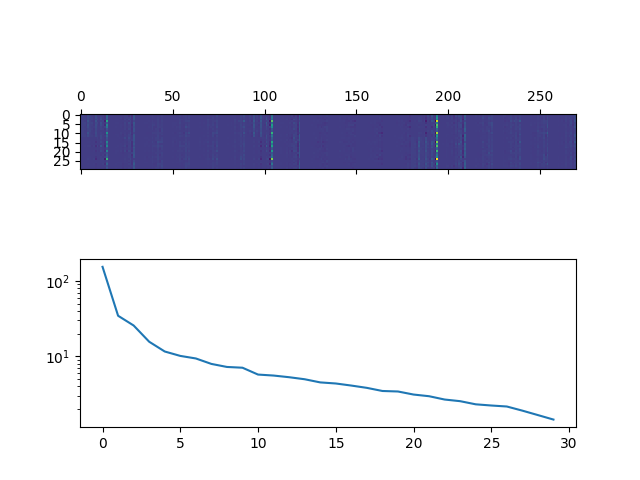

Time passed: 190.864048 s
Iterations: 115
Number of Atoms: 30
Minimal pair-distance: 2.089693
Singular-Value norm: 215.988096
Full Matrix norm: 82.111257
Block matrix norm: 49.138371
LJ-Cost: -17.587758


<IPython.core.display.Javascript object>


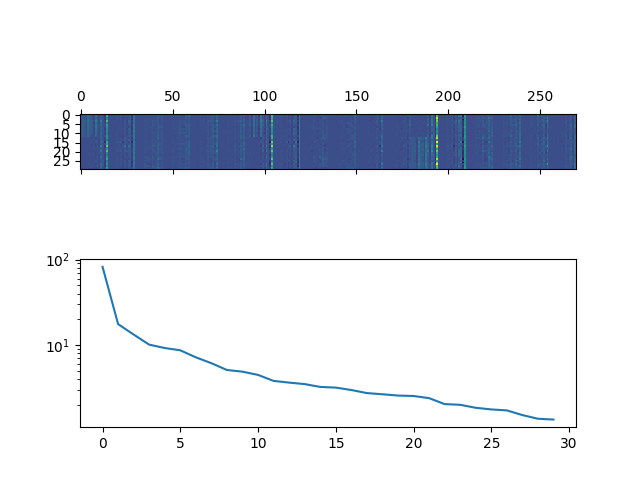

(82.11125695969592, -17.58775778087797)

In [8]:
norm_LJ_opt(seed=43, pbc=True, full_output=True)

Number of Atoms: 30
Minimal pair-distance: 2.001983
Singular-Value norm: 111.641177
Full Matrix norm: 31.067410
Block matrix norm: 23.457670
LJ-Cost: -2.421245


<IPython.core.display.Javascript object>


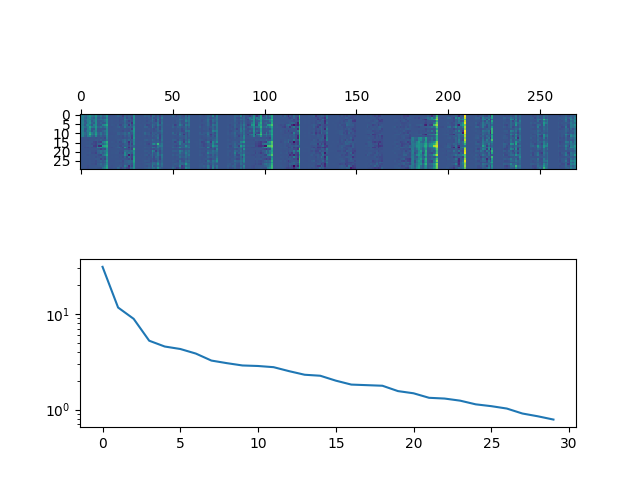

/users/stud/bechtelt/BA/code/soaputils.py:201: RuntimeWarning: divide by zero encountered in power
  np.power(r/sigma, -6, out=r)
/users/stud/bechtelt/BA/code/soaputils.py:202: RuntimeWarning: invalid value encountered in subtract
  return np.sum(r**2 - r - shift**2 + shift)*4*eps


Time passed: 18.843948 s
Iterations: 50
Number of Atoms: 30
Minimal pair-distance: 2.116066
Singular-Value norm: 52.931956
Full Matrix norm: 11.618325
Block matrix norm: 7.480503
LJ-Cost: -1.287487


<IPython.core.display.Javascript object>


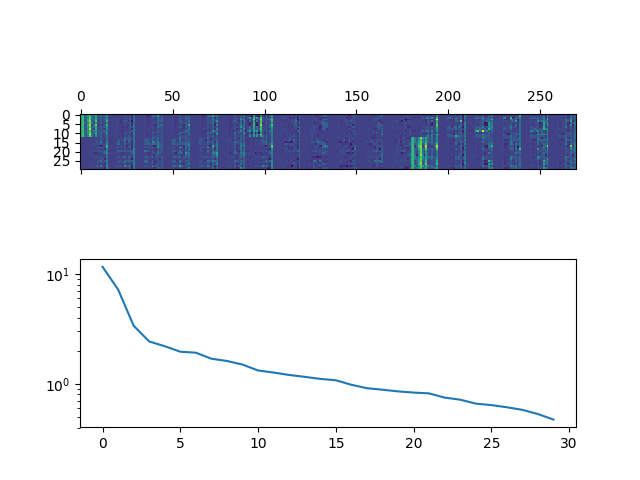

(11.61832515237778, -1.287487448588341)

In [6]:
norm_LJ_opt(seed=42, pbc=False, full_output=True)

In [ ]:
norm_LJ_opt(pbc=False)